# Deep Learning Tweet Analytics

Let's look into predicting whether a tweet has positive or negative sentiment.

** We first read in the tweet data present in train.csv file.

Keep only the sentiment and sentiment text in the data - the first and the last coumn

Print the number of positive and negative sentiment labels

In [25]:
# your code here
import pandas as pd

train = pd.read_csv('./HW3-data/train.csv',encoding='iso8859',header=None)
train = train.drop(columns=[1,2,3,4])
train_arr = train.values
print("0 corresponds to Negative Sentiments & 1 corresponds to Positive sentiments")
print(train[0].value_counts())

0 corresponds to Negative Sentiments & 1 corresponds to Positive sentiments
0    800000
1    800000
Name: 0, dtype: int64


In [26]:
from random import sample
train_arr_small = np.array(sample(list(train_arr),20000))
print("Negative Tweets in Sampled Training Data: ",len(train_arr_small[train_arr_small[:,0] == 0]))
print("Positive Tweets in Sampled Training Data: ",len(train_arr_small[train_arr_small[:,0] == 1]))

Negative Tweets in Sampled Training Data:  10077
Positive Tweets in Sampled Training Data:  9923


## Setting up an LSTM

In [27]:
# your code here
proper_train_size = int(len(train_arr_small) * 0.8)
val_size = len(train_arr_small) - proper_train_size
proper_train_dataset, val_dataset = torch.utils.data.random_split(train_arr_small,
                                                                  [proper_train_size,
                                                                   val_size])

In [28]:
from torchnlp.encoders.text import SpacyEncoder
encoder = SpacyEncoder([data[1] for data in proper_train_dataset])
proper_train_encoded = [encoder.encode(data[1]) for data in proper_train_dataset]

In [29]:
print(proper_train_dataset[1])
print(proper_train_encoded[1])
print([encoder.vocab[word_idx] for word_idx in proper_train_encoded[1]])

[1
 '@laurajdavis Do not complain - the sun will go away!  I really it want it to stay for the next 3 months!!! ']
tensor([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 25, 27,
        28, 29, 16, 30, 31, 32, 21, 21, 21])
['@laurajdavis', 'Do', 'not', 'complain', '-', 'the', 'sun', 'will', 'go', 'away', '!', ' ', 'I', 'really', 'it', 'want', 'it', 'to', 'stay', 'for', 'the', 'next', '3', 'months', '!', '!', '!']


In [30]:
proper_train_labels = torch.tensor([data[0] for data in proper_train_dataset])
val_encoded = [encoder.encode(data[1]) for data in val_dataset]
val_labels = torch.tensor([data[0] for data in val_dataset])
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))

In [31]:
# SpacyEncoder by default has <unk> implemented
encoder.vocab[:5]

['<pad>', '<unk>', '</s>', '<s>', '<copy>']

In [32]:
from torchnlp.word_to_vector import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

In [33]:
embedding_weights = torch.empty(encoder.vocab_size, pretrained_embedding.dim)
for i, token in enumerate(encoder.vocab):
    embedding_weights[i] = pretrained_embedding[token]

In [34]:
from UDA_pytorch_utils import UDA_LSTMforSequential
simple_lstm_model = nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))
summary(simple_lstm_model, torch.zeros((1, 5), dtype=torch.long))

                Kernel Shape Output Shape   Params Mult-Adds
Layer                                                       
0_0             [100, 31688]  [1, 5, 100]        -         -
1_1.LSTM_model             -   [1, 5, 64]  42.496k   41.984k
2_2                  [64, 2]       [1, 2]    130.0     128.0
-------------------------------------------------------------
                         Totals
Total params          3.211426M
Trainable params        42.626k
Non-trainable params    3.1688M
Mult-Adds               42.112k


C:\Users\nahse\anaconda3\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[100, 31688]","[1, 5, 100]",NaN,NaN
1_1.LSTM_model,-,"[1, 5, 64]",42496.0,41984.0
2_2,"[64, 2]","[1, 2]",130.0,128.0


In [35]:
import os
os.makedirs('./saved_model_checkpoints', exist_ok=True)

## Hyperparameter Tuning

  0%|          | 0/4 [00:00<?, ?it/s]

Learning Rate used:  0.01
Batch Size used:  64
Epoch 1 [==================================================] 16000/16000
  Train accuracy: 0.5534
  Validation accuracy: 0.5500
Epoch 2 [==================================================] 16000/16000
  Train accuracy: 0.5772
  Validation accuracy: 0.5707
Epoch 3 [==================================================] 16000/16000
  Train accuracy: 0.7053
  Validation accuracy: 0.6845
Epoch 4 [==================================================] 16000/16000
  Train accuracy: 0.7514
  Validation accuracy: 0.7177
Epoch 5 [==================================================] 16000/16000
  Train accuracy: 0.7204
  Validation accuracy: 0.6770
Epoch 6 [==================================================] 16000/16000
  Train accuracy: 0.7558
  Validation accuracy: 0.6923
Epoch 7 [==================================================] 16000/16000
  Train accuracy: 0.7577
  Validation accuracy: 0.6887
Epoch 8 [================================================

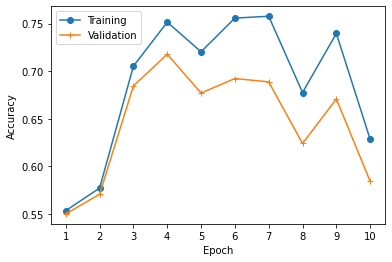

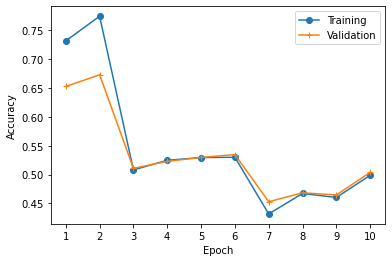

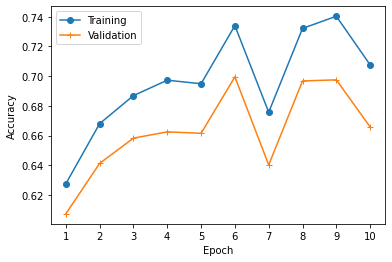

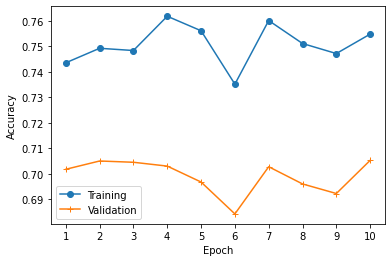

In [36]:
num_epochs = 10  # during optimization, how many times we look at training data
# batch_size = 64  # during optimization, how many training data to use at each step
# learning_rate = [0.1,0.05]  # during optimization, how much we nudge our solution at each step


hyperparameter_settings = [(learning_rate, batch_size)
                           for learning_rate in [0.01,0.05]
                           for batch_size in [64,128]]  

best_val_acc = -np.inf  # assumes that a higher score is better
best_epoch = None
best_hp = None
from tqdm.notebook import tqdm_notebook
for hp_set in tqdm_notebook(hyperparameter_settings):
    lr,bs = hp_set
    print("=========================")
    print("Learning Rate used: ",lr)
    print("Batch Size used: ",bs)
    train_accuracies, val_accuracies = \
        UDA_pytorch_classifier_fit(simple_lstm_model,
                                   torch.optim.Adam(simple_lstm_model.parameters(),
                                                    lr=lr),
                                   nn.CrossEntropyLoss(),  # includes softmax
                                   proper_train_dataset_encoded, val_dataset_encoded,
                                   num_epochs, bs,
                                   sequence=True,
                                   save_epoch_checkpoint_prefix='./saved_model_checkpoints/twitter_lstm_{}'.format(hp_set))

    best_epoch_idx = np.argmax(val_accuracies)
    print('The model at the end of epoch %d achieved the highest validation accuracy: %f'
          % (best_epoch_idx + 1, val_accuracies[best_epoch_idx]))
    
    if val_accuracies[best_epoch_idx] > best_val_acc:
        best_val_acc = val_accuracies[best_epoch_idx]
        best_hp = hp_set
        best_epoch = best_epoch_idx+1

    UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)

In [37]:
print("The model with parameters (learnig_rate,batch_size) as {} \n at the end of epoch {} achieved the highest validation accuracy: {}.".
      format(best_hp,best_epoch,best_val_acc))
simple_lstm_model.load_state_dict(torch.load('./saved_model_checkpoints/twitter_lstm_{}_epoch{}.pt'.
                                             format(best_hp,best_epoch)))

The model with parameters (learnig_rate,batch_size) as (0.01, 64) 
 at the end of epoch 4 achieved the highest validation accuracy: 0.71775.


<All keys matched successfully>

In [38]:
test = pd.read_csv('./HW3-data/test.csv',encoding='iso8859',header=None)
test = test.drop(columns=[1,2,3,4])
test_arr = test.values

In [39]:
test_encoded = [encoder.encode(data[1]) for data in test_arr]
test_labels = torch.tensor([data[0] for data in test_arr])

In [40]:
predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       sequence=True)
print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

Test accuracy: 0.5542168674698795


## Comparing LSTM Performance to that of a Random Forest Classifier

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Not combining Proper Training and Validation as given in instructions and because Proper Train is a big enough sample. 
# That is what the LSTM was trained on as well and would remain the same for comparision
encoder_vocabdict = {val:idx for idx,val in enumerate(encoder.vocab)}
proper_train_encoded_str = [" ".join(map(str,tweet.numpy().tolist())) for tweet in proper_train_encoded]

tf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.8,vocabulary=encoder_vocabdict,lowercase=False)
X_encoded_tf = tf_vectorizer.fit_transform(proper_train_encoded_str)
# vocab = list(tf_vectorizer.vocabulary_.keys())
tf_vocab = tf_vectorizer.vocabulary_

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


param_grid = {
#     'max_depth': [5, 20,None],
    'max_features': ["auto", 0.25,0.5],
    'min_samples_leaf': [1,10]}
    
rfc = RandomForestClassifier(random_state=0)
    
grid_search=GridSearchCV(rfc,param_grid=param_grid,cv=5,scoring='accuracy',n_jobs=-1,verbose=2)
    
grid_search.fit(X_encoded_tf,proper_train_labels)

print("The best Hyperparameter setting for RFC with CV accuracy {} is: {}".format(grid_search.best_score_,
      grid_search.best_params_))
rfc = grid_search.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best Hyperparameter setting for RFC with CV accuracy 0.599 is: {'max_features': 0.25, 'min_samples_leaf': 10}


In [48]:
test_encoded_str = [" ".join(map(str,tweet.numpy().tolist())) for tweet in test_encoded]
test_encoded_str_tf = tf_vectorizer.transform(test_encoded_str)
rfc_pred = rfc.predict(test_encoded_str_tf)
print('Test accuracy for Random Forest Classifier:', accuracy_score(test_labels,rfc_pred))

Test accuracy for Random Forest Classifier: 0.4959839357429719


The test accuracy with the Baseline Random Forest Classifier was worse than the LSTM but not by a big margin. The Test accuracy of the LSTM was 55.4% as compared to the 49.6% accuracy of the RFC. I would hope that with more data, the LSTM is able to learn more and perform better. ( An earlier run with 60000 data points had given a Test Accuracy of 60% for the LSTM )